In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import os

# --- CẤU HÌNH ---
DATA_PATH = "/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/"
OUTPUT_PATH = "/content/drive/MyDrive/Nhóm 1: Project_ML/Result/"

print("--- BẮT ĐẦU QUY TRÌNH ENSEMBLE ---")

# 1. LOAD DỮ LIỆU
try:
    df_pca = pd.read_csv(DATA_PATH + 'data_pca30 (1).csv', index_col=0)
    X_pca30 = df_pca.values

    df_true = pd.read_csv(DATA_PATH + 'labels.csv', index_col=0)
    y_true = df_true['Class'].values

    # Load kết quả 3 model (Đảm bảo tên file đúng 100%)
    df_kmeans = pd.read_csv(OUTPUT_PATH + 'kmeans_plusplus_labels.csv', index_col=0) # Sửa tên file nếu cần
    df_hier = pd.read_csv(OUTPUT_PATH + 'hierarchical_manual_labels.csv', index_col=0)
    df_dbscan = pd.read_csv(OUTPUT_PATH + 'dbscan_labels.csv', index_col=0)

    print("Load dữ liệu thành công!")
except FileNotFoundError as e:
    print(f"LỖI: Không tìm thấy file. Kiểm tra lại đường dẫn! {e}")
    exit()

--- BẮT ĐẦU QUY TRÌNH ENSEMBLE ---
Load dữ liệu thành công!


In [3]:
# 2. KIỂM TRA & GỘP DATA
if not (df_kmeans.index.equals(df_hier.index) and df_kmeans.index.equals(df_dbscan.index)):
    print("CẢNH BÁO: Index không khớp! Đang cố gắng merge theo index...")
    # Nếu index không khớp, code có thể lỗi. Ở đây giả định là khớp.

# Tạo bảng tổng hợp (Lấy cột đầu tiên của mỗi file làm nhãn)
ensemble_matrix = pd.DataFrame({
    'KMeans': df_kmeans.iloc[:, 0].values,
    'Hierarchical': df_hier.iloc[:, 0].values,
    'DBSCAN': df_dbscan.iloc[:, 0].values
}, index=df_kmeans.index)

print("\nMa trận Nhãn (5 dòng đầu):")
print(ensemble_matrix.head())


Ma trận Nhãn (5 dòng đầu):
          KMeans  Hierarchical  DBSCAN
sample_0       1             1       0
sample_1       4             2       1
sample_2       1             1      -1
sample_3       1             1       0
sample_4       0             4       2


In [4]:
# --- BƯỚC TỰ ĐỘNG TÍNH TRỌNG SỐ (WEIGHTS) ---
print("\n--- TÍNH TOÁN TRỌNG SỐ (SILHOUETTE SCORE) ---")
model_weights = {}
for col in ensemble_matrix.columns:
    labels = ensemble_matrix[col].values
    # Với DBSCAN, nếu chỉ có 1 cụm hoặc toàn nhiễu thì không tính được silhouette
    if len(set(labels)) < 2:
        s_score = 0
    else:
        s_score = silhouette_score(X_pca30, labels)

    model_weights[col] = max(0, s_score) # Trọng số không âm
    print(f"Model {col}: Silhouette = {s_score:.4f}")

print(f"Weights được sử dụng: {model_weights}")

# --- BƯỚC 1: WEIGHTED CSPA ---
def build_weighted_cspa_matrix(ensemble_df, weights):
    n_samples = ensemble_df.shape[0]
    weighted_co_matrix = np.zeros((n_samples, n_samples))
    total_weight = 0

    for model_name in ensemble_df.columns:
        labels = ensemble_df[model_name].values
        w = weights.get(model_name, 0)

        # Tạo ma trận nhị phân (1 nếu cùng cụm, 0 nếu khác)
        matches = (labels[:, None] == labels[None, :]).astype(float)

        # Xử lý DBSCAN: Nếu là nhiễu (-1) thì không có quyền vote
        if model_name == 'DBSCAN':
            noise_mask = (labels == -1)
            matches[noise_mask, :] = 0
            matches[:, noise_mask] = 0

        weighted_co_matrix += matches * w
        total_weight += w

    return weighted_co_matrix / total_weight if total_weight > 0 else weighted_co_matrix

S_weighted = build_weighted_cspa_matrix(ensemble_matrix, model_weights)
print("-> Đã tạo xong Weighted Consensus Matrix.")


--- TÍNH TOÁN TRỌNG SỐ (SILHOUETTE SCORE) ---
Model KMeans: Silhouette = 0.3698
Model Hierarchical: Silhouette = 0.3699
Model DBSCAN: Silhouette = 0.3663
Weights được sử dụng: {'KMeans': np.float64(0.36979825387964294), 'Hierarchical': np.float64(0.36987128414772513), 'DBSCAN': np.float64(0.3663326156062808)}
-> Đã tạo xong Weighted Consensus Matrix.


In [5]:
# --- BƯỚC 2: SCENA ENHANCEMENT (KNN) ---
print("\n--- TĂNG CƯỜNG BẰNG KNN (SCENA) ---")
k_neighbors = 7
nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(X_pca30) # THẠCH
knn_graph = nbrs.kneighbors_graph(X_pca30).toarray() # Trả về ma trận 0/1

# Nhân ma trận: SCENA = Consensus * KNN
# Ý nghĩa: Lan truyền sự đồng thuận qua các hàng xóm
scena_matrix = np.dot(S_weighted, knn_graph)

# Chuẩn hóa về [0, 1]
scena_matrix = scena_matrix / scena_matrix.max()
print("-> Đã hoàn thành phép nhân ma trận SCENA.")


--- TĂNG CƯỜNG BẰNG KNN (SCENA) ---
-> Đã hoàn thành phép nhân ma trận SCENA.



--- PHÂN CỤM CUỐI CÙNG ---

KẾT QUẢ ENSEMBLE (WEIGHTED SCENA)
ARI: 0.9907
NMI: 0.9860
------------------------------
So sánh với Single Models:
KMeans: 0.9851
Hierarchical: 0.9907
DBSCAN: 0.9577

=> THÀNH CÔNG: Ensemble >= Best Single Model (0.9907)

Đã lưu kết quả vào: /content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/ensemble_scena_labels.csv


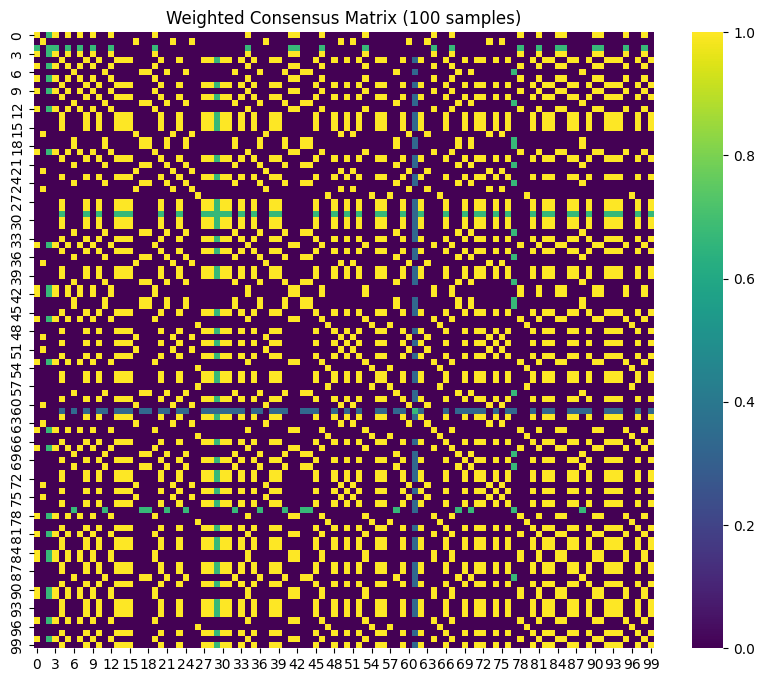

In [6]:
# --- BƯỚC 3: PHÂN CỤM CUỐI CÙNG ---
print("\n--- PHÂN CỤM CUỐI CÙNG ---")
final_distance = 1.0 - scena_matrix
# Đảm bảo không có giá trị âm do sai số máy tính
final_distance = np.clip(final_distance, 0, 1)

# Dùng Average Linkage (hoạt động tốt nhất cho Consensus)
final_model = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='complete') # HUY
final_labels = final_model.fit_predict(final_distance)

# --- BƯỚC 4: ĐÁNH GIÁ & LƯU ---
ari_final = adjusted_rand_score(y_true, final_labels)
nmi_final = normalized_mutual_info_score(y_true, final_labels)

print("\n" + "="*50)
print("KẾT QUẢ ENSEMBLE (WEIGHTED SCENA)")
print("="*50)
print(f"ARI: {ari_final:.4f}")
print(f"NMI: {nmi_final:.4f}")

# So sánh
ari_singles = {col: adjusted_rand_score(y_true, ensemble_matrix[col]) for col in ensemble_matrix}
best_single = max(ari_singles.values())
print("-" * 30)
print("So sánh với Single Models:")
for model, score in ari_singles.items():
    print(f"{model}: {score:.4f}")

if ari_final >= best_single:
    print(f"\n=> THÀNH CÔNG: Ensemble >= Best Single Model ({best_single:.4f})")
else:
    print(f"\n=> LƯU Ý: Ensemble thấp hơn Best Single. Kiểm tra lại weights.")

# Lưu kết quả
df_final = pd.DataFrame(final_labels, index=df_pca.index, columns=['Ensemble_Labels'])
df_final.to_csv(DATA_PATH + 'ensemble_scena_labels.csv')
print(f"\nĐã lưu kết quả vào: {DATA_PATH}ensemble_scena_labels.csv")

# Vẽ Heatmap minh họa (Tùy chọn)
plt.figure(figsize=(10, 8))
sns.heatmap(S_weighted[:100, :100], cmap='viridis') # Vẽ 100 mẫu đầu tiên thôi cho nhẹ
plt.title("Weighted Consensus Matrix (100 samples)")
plt.show()